In [244]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [245]:
c1 = 0.5 # now
c2 = 0.75 # in september
b = 1 # after september
h = 0.1
kappa = (b-c2)/(b+h)

## Solving a single-stage problem (exercise a)

In [246]:
c = c1 # let's consider the situation in exercises (a) and (b)

def cost(y, A, B):
    return b * (A+B) / 2 + (c-b) * y - (b+h) * (A-y)*(A-y) / (2*(A-B))

# formula (1.6) in Shapiro's tutorial
def solve_second_exact(A, B):
    k = (b - c) / (b + h)
    y = A * (1-k) + B * k
    return y, cost(y, A, B)

# problem (2.5) in Shapiro's tutorial
def solve_second_MC(A, B, K):
    scenarios = np.random.uniform(low=A, high=B, size=K)

    y = cp.Variable(1)
    t = cp.Variable(K)
    objective = cp.Minimize(cp.sum(t) / K)
    constraints = [y >= 0]

    for i, dk in enumerate(scenarios):
        constraints.append((c-b) * y - t[i] <= -b * dk)
        constraints.append((c+h) * y - t[i] <= h * dk)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    candidate = y.value[0]
    return candidate, prob.value

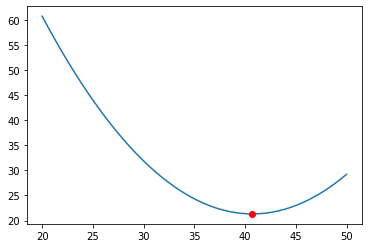

In [247]:
x = np.linspace(20, 50)
plt.plot(x, cost(x, 38, 44))
y, cst = solve_second_exact(38, 44)
plt.plot(y, cst, 'ro');

In [248]:
y1, cost1 = solve_second_exact(38, 44)
y2, cost2 = solve_second_MC(38, 44, 1000)
print(f'exact solution: {y1}, with cost: {cost1}')
print(f'MC solution: {y2}, with cost: {cost2}')

exact solution: 40.72727272727273, with cost: 21.318181818181817
MC solution: 40.71708562750193, with cost: 21.30594208765749


## Solving the two-stage version (exercise c)

### Monte Carlo for first stage only

We first express $Q(x, \xi)$ in terms of $x,A,B$.

In [250]:
# for A <= x <= B
def d2(A, B):
    return (b+h) / (2*(B-A))
def d1(A, B):
    return (A/(A-B)) * (b+h) -c2 + c1
def d0(A, B):
    return ((b+h)*A*A) / (2 * (B-A))

# for x > B
Bd1 = b + h -c2 + c1
def Bd0(A, B):
    return (b+h) * ((B-A) / 2 - B)

# constant term in Q
def C(A, B):
    k = (b-c2)/(b+h)
    l = A + k*(B-A)
    return b*(A+B)/2 + (c2 - b) * l + (b+h)*(B - A)*k*k/2

# we define the cost function piecewise
def Q(x, A, B):
    if A <= x <= B:
        return d2(A, B) * x*x + d1(A, B) * x + d0(A, B) + C(A,B)
    elif x > B:
        return Bd1 * x + Bd0(A, B) + C(A,B)
    else:
        return (-c2 + c1) *x + C(A,B)

optimal x: 39.36363636363636


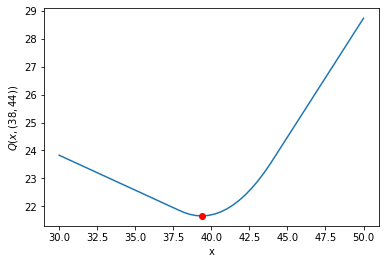

In [251]:
# solve an example for given A, B
A = 38
B = 44
xs = np.linspace(30, 50)
y = [Q(x, A, B) for x in xs]

def x_opt(d1, d2):
    return -d1/(2*d2) # extreme point of parabola

s = x_opt(d1(A, B), d2(A, B))

plt.plot(xs, y)
plt.plot(s, Q(s, A, B), 'ro')
plt.xlabel('x'); plt.ylabel(r'$Q(x,(38,44))$')
plt.savefig('example_Q.pdf')
print(f'optimal x: {s}')

We can now perform a straightforward grid search on $x$ to find a value close to the optimum.

In [252]:
def get_bounds(N, low=38, high=44):
    # samples ksi_i = (A_i, B_i) = (min(U_1, U_2), max(U_1, U_2)), where U_i ~ Uni[38, 44]
    res = np.sort(np.random.uniform(low=low, high=high, size=(N,2)), axis=1)
    return res

def get_Q(xs, Q, bounds):
    As, Bs = bounds[:,0], bounds[:,1]
    def objective(x):
        res = 0
        for A, B in zip(As, Bs):
            res += Q(x, A, B)
        return res / len(bounds)

    return [objective(x) for x in xs]

solution x=39.6426, with cost=21.0675
solution x=39.6306, with cost=21.1205
solution x=39.6326, with cost=21.1488
solution x=39.8048, with cost=21.1796
solution x=39.7888, with cost=21.1861


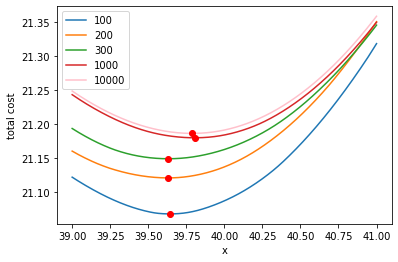

In [253]:
def find_solution(N):
    xs =  np.linspace(39, 41, num=1000)
    ys = get_Q(xs, Q, get_bounds(N))
    args = {'color': 'pink'} if N > 1000 else {} # default color is hard to distinguish from the first
    plt.plot(xs, ys, label=N, **args)
    s = xs[np.argmin(ys)]
    cst = np.min(ys)
    plt.plot(s, cst, 'ro')
    plt.xlabel('x')
    plt.ylabel('total cost')
    print(f'solution x={s:.4f}, with cost={cst:.4f}')

find_solution(100)
find_solution(200)
find_solution(300)
find_solution(1000)
find_solution(10000)
plt.legend()
plt.savefig('MC_grid.pdf')

## Value of storage unit (exercise d)

39.85585585585586 39.96396396396396
cost difference = -0.015004951453605031


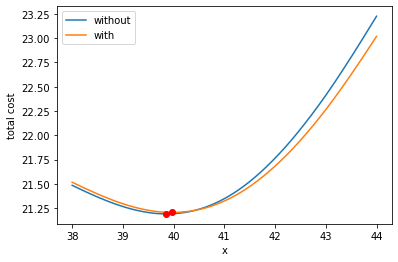

In [257]:
def integral(y, x, A, B):
    if A <= x+y <= B:
        return (x+y-A)*(x+y-A) / (2*(B-A))
    elif x+y > B:
        return x+y - (A+B)/2
    else:
        return 0

def Q1(x, A, B):
    y_hat = A + kappa*(B-A) - x

    return c1*x + b*(A+B)/2 - b*x + (c2 - b) * y_hat \
        + (b+h)*(integral(x,0,A,B) + integral(y_hat,x,A,B))

def Q2(x, A, B, s=3):
    y_hat = (s*h)/(b+h) + A + kappa*(B-A) - x

    return c1*x + b*(A+B)/2 - b*x + (c2 - b) * y_hat \
        + b*(integral(x,0,A,B) + integral(y_hat,x,A,B)) \
        + h*(integral(x,-s,A,B) + integral(y_hat,x-s,A,B))

N = 1000
xs =  np.linspace(38, 44, num=1000)
bounds = get_bounds(N)
y1 = get_Q(xs, Q1, bounds)
y2 = get_Q(xs, Q2, bounds)
plt.plot(xs, y1, label='without')
plt.plot(xs, y2, label='with')
s1 = xs[np.argmin(y1)]
cst1 = np.min(y1)
s2 = xs[np.argmin(y2)]
cst2 = np.min(y2)
plt.plot(s1, cst1, 'ro')
plt.plot(s2, cst2, 'ro')
plt.xlabel('x')
plt.ylabel('total cost')
plt.legend()
plt.savefig('storage.pdf')

print(s1, s2)
print(f'cost difference = {cst1 - cst2}')

There is probably something wrong with our calculations, because we expect the cost with the storage unit to be lower.

### Sanity check
To check whether both methods actually compute the same values. Initially, we did not use the "integral" utility function and we wanted to split all the coefficients, because we anticipated on analytically deriving their expected value. However, we can greatly reduce the complexity of the expressions by simply using this "integral" utility function as shown below.

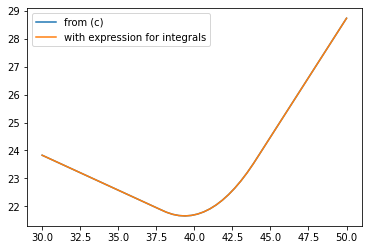

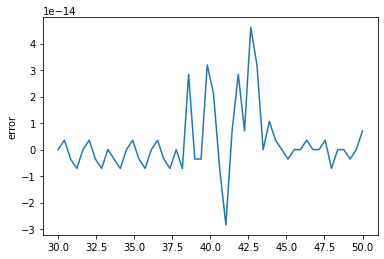

In [203]:
A=38
B=44

xs = np.linspace(30, 50)

# cost
cst1 = [Q(x, A, B) for x in xs]
cst2 = [Q1(x, A, B) for x in xs]
plt.plot(xs, cst1, label='from (c)')
plt.plot(xs, cst2, label='with expression for integrals')
plt.legend()
plt.show()
plt.plot(xs, np.array(cst1) - np.array(cst2))
plt.ylabel('error');